In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport mutation_features, methylation_pred, somatic_mut_clock, methylation_motifs
%autoreload 1
import get_data, utils, mutation_features, methylation_pred, somatic_mut_clock

/cellar/users/zkoch/miniconda3/envs/tf_env/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/cellar/users/zkoch/miniconda3/envs/tf_env/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb


%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


In [ ]:
motif_occurence_df = pd.read_parquet(
        "/cellar/users/zkoch/methylation_and_mutation/data/methylation_motifs_weiWang/motif_occurences/motif_occurences_combined_15kb.parquet"
        )

# Read ICGC

In [27]:
# qnorm 
icgc_mut_w_age_df, illumina_cpg_locs_df, icgc_methyl_age_df_t, icgc_matrix_qtl_dir, icgc_covariate_fn = get_data.read_icgc_data()

reading in data
Got mutations and metadata, reading methylation
Got methylation, transposing
Done


# Read TCGA

In [4]:
# qnorm data
all_mut_w_age_df, illumina_cpg_locs_df, all_methyl_age_df_t, matrix_qtl_dir, covariate_fn = get_data.read_tcga_data(qnorm_methylation = False)

reading in data
Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [8]:
all_methyl_age_df_t.isna().sum().sum()

0

In [ ]:
mut_feat_tcga_dict = {}
somage_tcga_dict = {}

# for each cv iteration
for cv_num in [0]:
    # create a mutation features object
    mut_feat_tcga = mutation_features.mutationFeatures(
        all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
        all_methyl_age_df_t = all_methyl_age_df_t, out_dir = "./", 
        consortium = 'TCGA', dataset = '', cross_val_num = cv_num,
        matrix_qtl_dir = matrix_qtl_dir,
        covariate_fn = covariate_fn, motif_occurence_df = pd.DataFrame()
    )
    # add to dictionary
    mut_feat_tcga_dict[cv_num] = mut_feat_tcga
    # and create a somage object from the seperate somage outputs
    somage_tcga = somatic_mut_clock.mutationClock.construct_from_paths(
        somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output",
        directory_glob = f"TCGA__500correl_0meqtl_50000nearby_Bothagg_1000numCpGs_*startTopCpGs_500extendAmount_{cv_num}crossValNum",
        file_suffix = "xgboost_nonebaseline_agg_only",
        mut_feat = mut_feat_tcga,
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        all_methyl_age_df_t = all_methyl_age_df_t,
        out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/071823_tcga_somage_output"
        )
    # read in pre-comp prediction performance by dset
    #somage_tcga.performance_by_dataset_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/062623_tcga_somage_output/pred_methyl_and_perf_by_dset/performance_by_dataset_CV{cv_num}.parquet")
    # add to dictionary
    somage_tcga_dict[cv_num] = somage_tcga

# Create features

In [6]:
# pivot icgc_mut_w_age_df to wide format on with case_submitter_id becoming rows, mut_loc columns, and values being the DNA_VAF
icgc_mut_w_age_df['mut_loc'] = icgc_mut_w_age_df['chr'].astype(str) + ':' + icgc_mut_w_age_df['start'].astype(str)

In [ ]:
# iterate across chromosomes, create wide matrices of mutation data
tissue_w_enough_samples = ['PRAD', 'PACA']
mut_matrix_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/081423_linear_methyl_pred_output/icgc_mut_wide_matrices"
for chrom in range(1,24):
    chrom = str(chrom)
    icgc_mut_w_age_wide_df = pd.pivot_table(
        icgc_mut_w_age_df.query("dataset in @tissue_w_enough_samples and chr == @chrom"), index='case_submitter_id', columns='mut_loc',
        values='DNA_VAF', fill_value = 0
        )
    icgc_mut_w_age_wide_df.to_parquet(f"{mut_matrix_dir}/icgc_mut_w_age_wide_df_chr{chrom}.parquet")
    print(chrom)

## distnace

In [ ]:
# sum mutations in nearby CpGs (within 10kb) for each CpG, outputting as parquet files
tissue_w_enough_samples = ['PRAD', 'PACA']
cpgs_w_methyl = icgc_methyl_age_df_t.columns.tolist()[3:]
illumina_cpg_locs_w_methyl_df = illumina_cpg_locs_df.rename(columns = lambda value: value.replace('#', '_')).query("_id in @cpgs_w_methyl").rename(columns = {'_id': '#id'})
MAX_DIST = 2500
mut_burden_dir =  f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/081423_linear_methyl_pred_output/icgc_mut_burden_feat_{MAX_DIST*2}kb_window"
if not os.path.exists(mut_burden_dir):
    os.makedirs(mut_burden_dir)
    
def sum_nearby_mutations(
    chrom: str,
    cpg_start: int,
    mut_matrix_df: pd.DataFrame,
    max_dist: int = 5000,
    ):
    # generate a list of locations within max_dist of cpg_start
    possible_mut_locs = [chrom + ':' + str(cpg_start + i) for i in range((-max_dist), max_dist + 1)]
    # select these locations from the mutation matrix
    nearby_mutated_locs = list(set(mut_matrix_df.columns).intersection(possible_mut_locs))
    return mut_matrix_df[nearby_mutated_locs].sum(axis=1)

for chrom in range(1,23):
    chrom = str(chrom)
    print(chrom)
    mut_matrix_df = pd.read_parquet(f"{mut_matrix_dir}/icgc_mut_w_age_wide_df_chr{chrom}.parquet")
    print(mut_matrix_df.shape)
    this_chr_cpg_locs_df = illumina_cpg_locs_w_methyl_df.query("chr == @chrom").set_index('#id', drop = True)
    print(this_chr_cpg_locs_df.shape)
    # for each of these cpgs, get the sum of mutation counts in the nearby CpGs (within MAX_DIST) 
    dist_mut_burdens_df = this_chr_cpg_locs_df.apply(
        lambda cpg_row: sum_nearby_mutations(chrom, cpg_row['start'], mut_matrix_df, max_dist=MAX_DIST), axis=1
        )
    print(dist_mut_burdens_df.shape)
    dist_mut_burdens_df.to_parquet(f"{mut_burden_dir}/icgc_mut_burden_{MAX_DIST*2}_nearby_cpgs_chr{chrom}.parquet")
    

## Create CpG coherence features

In [ ]:
# sum mutations in nearby CpGs (within 10kb) for each CpG, outputting as parquet files
tissue_w_enough_samples = ['PRAD', 'PACA']
cpgs_w_methyl = icgc_methyl_age_df_t.columns.tolist()[3:]
illumina_cpg_locs_w_methyl_df = illumina_cpg_locs_df.rename(
    columns = lambda value: value.replace('#', '_')
    ).query("_id in @cpgs_w_methyl").rename(columns = {'_id': '#id'})
illumina_cpg_locs_w_methyl_df['cpg_loc'] = illumina_cpg_locs_w_methyl_df['chr'] + ':' + illumina_cpg_locs_w_methyl_df['start'].astype(str)
CORR_THRESH = .4
mut_burden_dir =  f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/081423_linear_methyl_pred_output/icgc_mut_burden_feat_{CORR_THRESH}coherence"
# make the directory if it doesn't exist    
if not os.path.exists(mut_burden_dir):
    os.makedirs(mut_burden_dir)
corr_dir = "/cellar/users/zkoch/methylation_and_mutation/data/final_icgc_data/chr_dset_corrs_qnorm"

def sum_coherent_mutations(
    cpg_id: str,
    mut_matrix_df: pd.DataFrame,
    corr_df: pd.DataFrame,
    cpg_locs_df: pd.DataFrame,
    corr_threshold: float,
    ):
    # get the CpGs that are above corr_threshold with this CpG
    cpgs_above_corr_thresh = corr_df.loc[corr_df[cpg_id] > corr_threshold, cpg_id].index.tolist()
    # get the location of these Cpgs
    cpg_locs = set(cpg_locs_df.loc[cpgs_above_corr_thresh, 'cpg_loc'])
    # get the intersection of these with mutated locs
    mut_locs = set(mut_matrix_df.columns)
    corr_mut_locs = list(mut_locs.intersection(cpg_locs))
    # get the sum of mutations in these locs in each sample
    return mut_matrix_df.loc[:, corr_mut_locs].sum(axis=1)

for chrom in range(1,23):
    this_chr_burdens_dfs = []
    for tissue in ['PRAD', 'PACA']:
        chrom = str(chrom)
        print(chrom)
        mut_matrix_df = pd.read_parquet(f"{mut_matrix_dir}/icgc_mut_w_age_wide_df_chr{chrom}.parquet")
        # subset to samples from this tissue
        this_tissue_methyl_samples = set(icgc_methyl_age_df_t.query("dataset == @tissue").index)
        this_tissue_mut_samples = set(mut_matrix_df.index.tolist())
        mut_matrix_df = mut_matrix_df.loc[
            list(this_tissue_methyl_samples.intersection(this_tissue_mut_samples)), :
                ]
        
        this_chr_cpg_locs_df = illumina_cpg_locs_w_methyl_df.query(
            "chr == @chrom"
            ).set_index('#id', drop = False)
        this_chr_dset_corr_df = pd.read_parquet(os.path.join(corr_dir, f"chr{chrom}_{tissue}.parquet")).abs()
        # for each of these cpgs, get the sum of mutation counts in the nearby CpGs (within MAX_DIST) 
        dist_mut_burdens_df = this_chr_cpg_locs_df.apply(
            lambda cpg_row: sum_coherent_mutations(
                cpg_row['#id'], mut_matrix_df, this_chr_dset_corr_df, this_chr_cpg_locs_df, corr_threshold=CORR_THRESH
                ), axis=1
            )
        this_chr_burdens_dfs.append(dist_mut_burdens_df)
    corr_mut_burdens_df = pd.concat(this_chr_burdens_dfs, axis=1)
    corr_mut_burdens_df.to_parquet(
        f"{mut_burden_dir}/icgc_mut_burden_{CORR_THRESH}corr_cpgs_chr{chrom}.parquet"
        )
    

# Get correlation between mut burdens and CpGm

In [ ]:
# corr-based
tissue_w_enough_samples = ['PACA', 'PRAD']
CORR_THRESH = .4
corr_dir = f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/081423_linear_methyl_pred_output/icgc_mut_burden_feat_{CORR_THRESH}coherence_corrs"
if not os.path.exists(corr_dir):
    os.makedirs(corr_dir)
mut_burden_dir =  f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/081423_linear_methyl_pred_output/icgc_mut_burden_feat_{CORR_THRESH}coherence"
for tissue in tissue_w_enough_samples:
    spearman_corr_df_list = []  
    pearson_corr_df_list = []
    for chrom in range(1,23):
        # read in mutation burden data
        dist_mut_burdens_df = pd.read_parquet(f"{mut_burden_dir}/icgc_mut_burden_{CORR_THRESH}corr_cpgs_chr{chrom}.parquet")
        # transpose so that each row is a sample
        dist_mut_burdens_df = dist_mut_burdens_df.transpose()
        # select corresponding methylation data
        methylation_df = icgc_methyl_age_df_t[dist_mut_burdens_df.columns.tolist() + ['dataset']]
        # select the samples from tissue that have both methylation and mutation burden data
        samples_w_both_data = dist_mut_burdens_df.index.intersection(methylation_df.query("dataset == @tissue").index)
        # subset both matrices to only include samples with both data
        dist_mut_burdens_df = dist_mut_burdens_df.loc[samples_w_both_data]
        methylation_df = methylation_df.loc[samples_w_both_data].drop(columns=['dataset'])
        # get pairwise correlations between mutation burden and methylation
        spearman_corrs = dist_mut_burdens_df.corrwith(methylation_df, method='spearman')
        pearson_corrs = dist_mut_burdens_df.corrwith(methylation_df, method='pearson')
        spearman_corr_df_list.append(spearman_corrs)
        pearson_corr_df_list.append(pearson_corrs)
        print(f"Done with chromosome {chrom} for tissue {tissue}")
    spearman_corr_df = pd.concat(spearman_corr_df_list, axis=0).to_frame().rename(columns={0:'spearman'})
    pearson_corr_df = pd.concat(pearson_corr_df_list, axis=0).to_frame().rename(columns={0:'pearson'})
    spearman_corr_df.to_parquet(f"{corr_dir}/{tissue}_spearman_corrs.parquet")
    pearson_corr_df.to_parquet(f"{corr_dir}/{tissue}_pearson_corrs.parquet")

In [ ]:
# distance-based
MAX_DIST = 2500
mut_burden_dir =  f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/081423_linear_methyl_pred_output/icgc_mut_burden_feat_{MAX_DIST*2}kb_window"
  
corr_dir = f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/081423_linear_methyl_pred_output/icgc_mut_burden_feat_{MAX_DIST*2}kb_window_corrs"
if not os.path.exists(corr_dir):
    os.makedirs(corr_dir)
tissue_w_enough_samples = ['PACA', 'PRAD']

for tissue in tissue_w_enough_samples:
    spearman_corr_df_list = []  
    pearson_corr_df_list = []
    for chrom in range(1,23):
        # read in mutation burden data
        dist_mut_burdens_df = pd.read_parquet(f"{mut_burden_dir}/icgc_mut_burden_{MAX_DIST*2}_nearby_cpgs_chr{chrom}.parquet")
        # transpose so that each row is a sample
        dist_mut_burdens_df = dist_mut_burdens_df.transpose()
        # select corresponding methylation data
        methylation_df = icgc_methyl_age_df_t[dist_mut_burdens_df.columns.tolist() + ['dataset']]
        # select the samples from tissue that have both methylation and mutation burden data
        samples_w_both_data = dist_mut_burdens_df.index.intersection(methylation_df.query("dataset == @tissue").index)
        # subset both matrices to only include samples with both data
        dist_mut_burdens_df = dist_mut_burdens_df.loc[samples_w_both_data]
        methylation_df = methylation_df.loc[samples_w_both_data].drop(columns=['dataset'])
        # get pairwise correlations between mutation burden and methylation
        spearman_corrs = dist_mut_burdens_df.corrwith(methylation_df, method='spearman')
        pearson_corrs = dist_mut_burdens_df.corrwith(methylation_df, method='pearson')
        spearman_corr_df_list.append(spearman_corrs)
        pearson_corr_df_list.append(pearson_corrs)
        print(f"Done with chromosome {chrom} for tissue {tissue}")
    spearman_corr_df = pd.concat(spearman_corr_df_list, axis=0).to_frame().rename(columns={0:'spearman'})
    pearson_corr_df = pd.concat(pearson_corr_df_list, axis=0).to_frame().rename(columns={0:'pearson'})
    spearman_corr_df.to_parquet(f"{corr_dir}/{tissue}_spearman_corrs.parquet")
    pearson_corr_df.to_parquet(f"{corr_dir}/{tissue}_pearson_corrs.parquet")

# Compare correlations across distances and windows

In [12]:
coherence_4_corr_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/081423_linear_methyl_pred_output/icgc_mut_burden_feat_0.4coherence_corrs"
coherence_3_corr_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/081423_linear_methyl_pred_output/icgc_mut_burden_feat_0.3coherence_corrs"
distance_10kb_corr_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/081423_linear_methyl_pred_output/icgc_mut_burden_feat_10kb_window_corrs"
distnace_5kb_corr_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/081423_linear_methyl_pred_output/icgc_mut_burden_feat_5000kb_window_corrs"
corr_dirs = {'coherence_4': coherence_4_corr_dir, 'coherence_3': coherence_3_corr_dir, 'distance_10kb': distance_10kb_corr_dir, 'distance_5kb': distnace_5kb_corr_dir}
corr_dfs = {}
for name, corr_dir in corr_dirs.items():
    for tissue in ['PRAD', 'PACA']:
        corr_df = pd.read_parquet(os.path.join(corr_dir, tissue + '_pearson_corrs.parquet'))
        corr_df['tissue'] = tissue
        corr_df['burden_metric'] = name
        corr_dfs[name + '_' + tissue] = corr_df

In [22]:
# combine corr_dfs into one
corr_df = pd.concat(corr_dfs, axis=0)
corr_df.reset_index(inplace=True)


<Axes: xlabel='abs_pearson', ylabel='Density'>

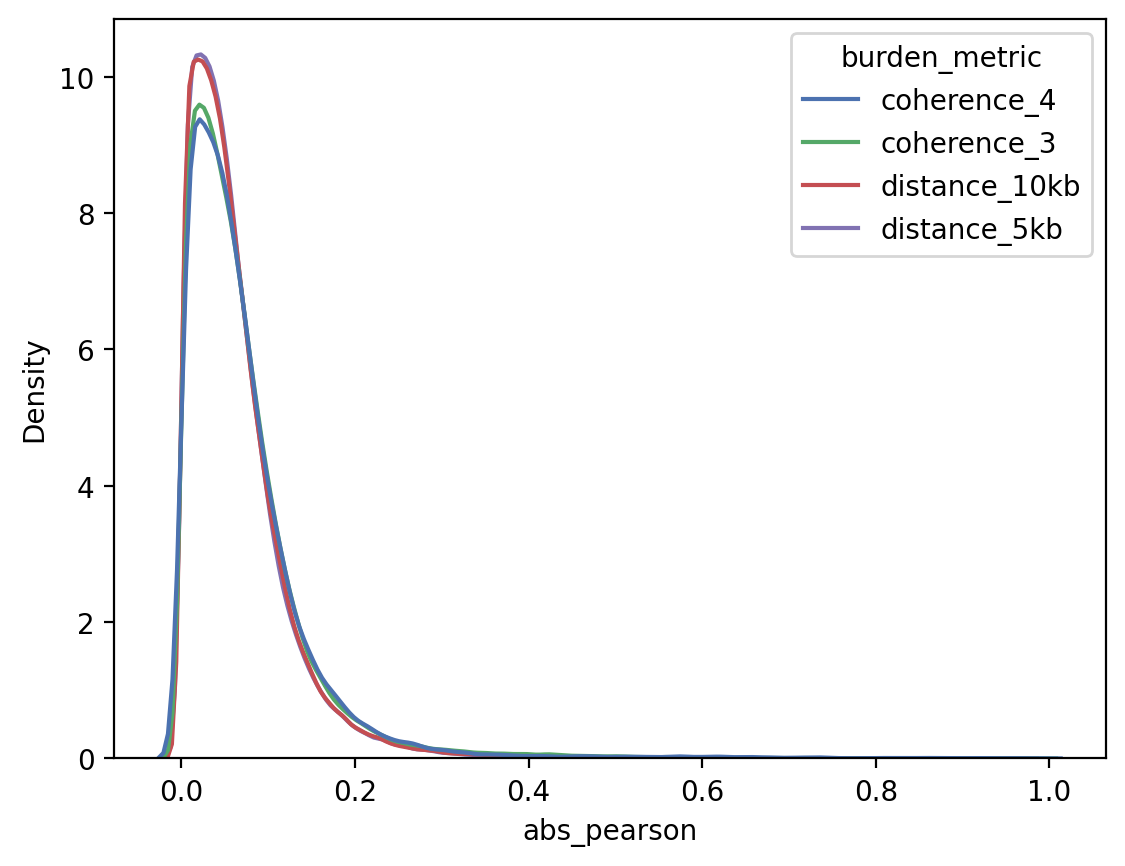

In [39]:
sns.kdeplot(
    data=corr_df.query("tissue == 'PACA'"), hue = 'burden_metric', x = 'abs_pearson',
    common_norm = False,
    )

In [37]:
corr_df['abs_pearson'] = corr_df['pearson'].abs()

In [41]:
corr_df.groupby('level_0')['abs_pearson'].describe(percentiles=[0.95, .99])

,count,mean,std,min,50%,95%,99%,max
level_0,,,,,,,,
coherence_3_PACA,131997.0,0.071100,0.071879,1.200834e-06,0.053947,0.191664,0.370121,0.987228
coherence_3_PRAD,163004.0,0.052999,0.047087,6.048195e-07,0.043154,0.131269,0.195561,0.968467
coherence_4_PACA,57156.0,0.071987,0.076686,5.783216e-08,0.054030,0.191351,0.373364,0.987228
coherence_4_PRAD,99308.0,0.050901,0.046586,4.642223e-08,0.041507,0.124492,0.186124,0.968203
distance_10kb_PACA,177078.0,0.063850,0.058991,6.102690e-08,0.049937,0.168953,0.282871,0.969717
distance_10kb_PRAD,236570.0,0.051811,0.045738,1.899892e-08,0.041525,0.132422,0.206336,0.961397
distance_5kb_PACA,111685.0,0.063397,0.058747,9.545018e-08,0.049563,0.168078,0.279295,0.956698
distance_5kb_PRAD,161334.0,0.051051,0.045934,7.736216e-07,0.040745,0.130684,0.207280,0.888981


<Axes: xlabel='abs_pearson', ylabel='Density'>

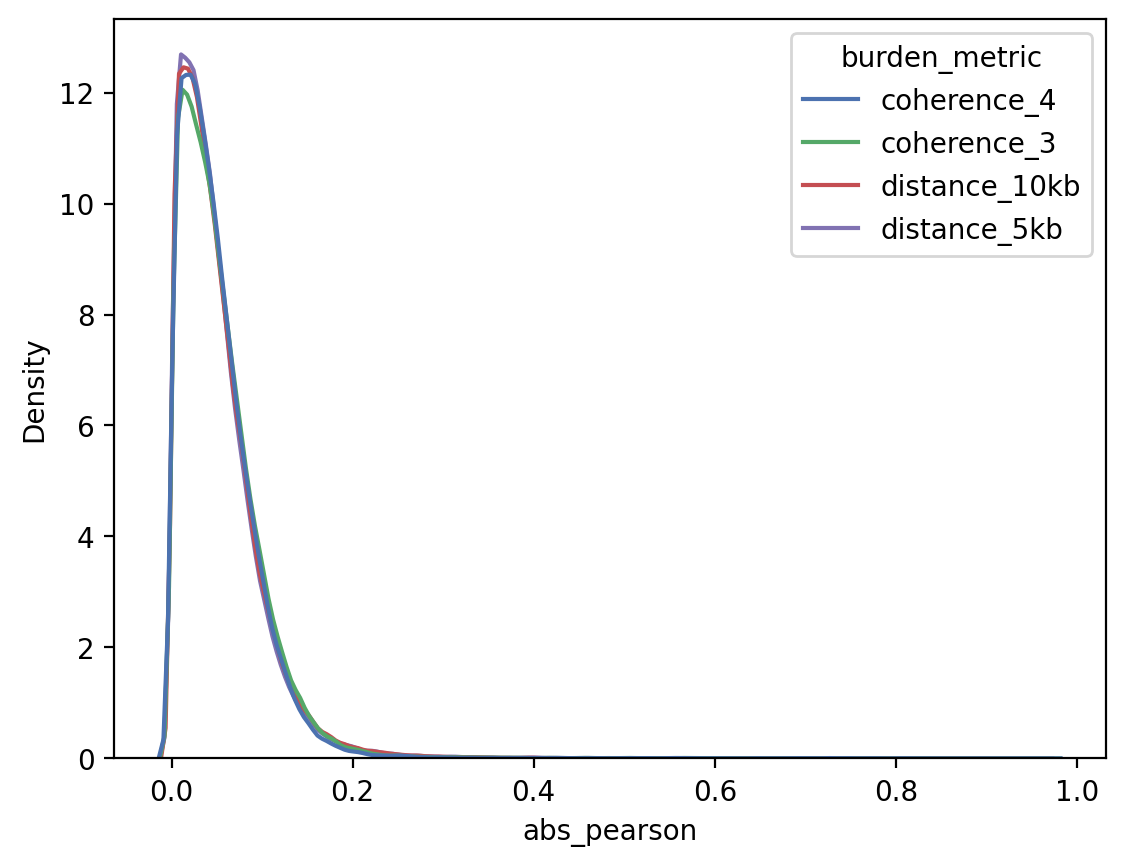

In [40]:
sns.kdeplot(
    data=corr_df.query("tissue == 'PRAD'"), hue = 'burden_metric', x = 'abs_pearson',
    common_norm = False,
    )

# Spearman and Pearson are nearly identical

In [19]:
spearman_corr_df.dropna(inplace=True)
pearson_corr_df.dropna(inplace=True)
# subset both to shared index
shared_index = spearman_corr_df.index.intersection(pearson_corr_df.index)
spearman_corr_df = spearman_corr_df.loc[shared_index]
pearson_corr_df = pearson_corr_df.loc[shared_index]

In [21]:
pearsonr(pearson_corr_df['pearson'], spearman_corr_df['spearman'])

PearsonRResult(statistic=0.8727234562081536, pvalue=0.0)

In [22]:
spearmanr(pearson_corr_df['pearson'], spearman_corr_df['spearman'])

SignificanceResult(statistic=0.9312490243027061, pvalue=0.0)

Text(0, 0.5, 'Spearman correlation')

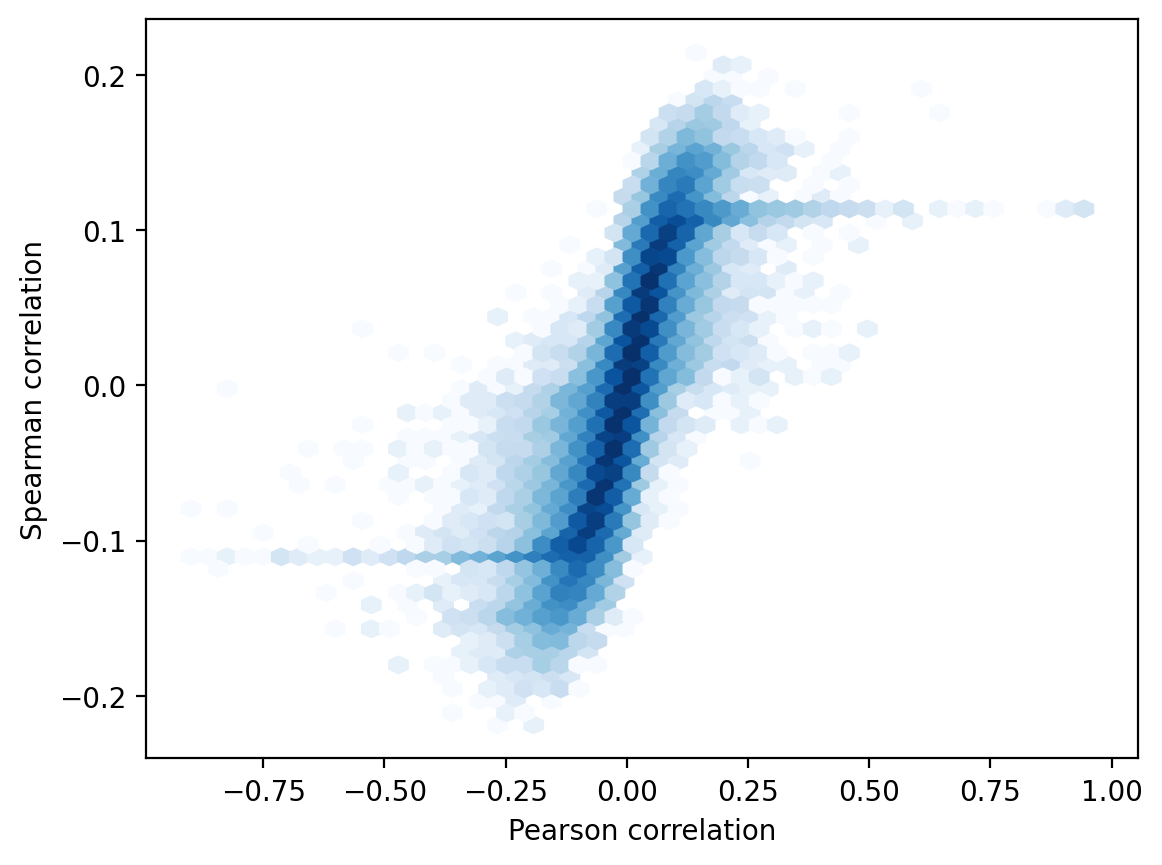

In [28]:
plt.hexbin(pearson_corr_df['pearson'], spearman_corr_df['spearman'], gridsize=50, cmap='Blues', bins='log')
plt.xlabel('Pearson correlation')
plt.ylabel('Spearman correlation')

# Compare clocks

In [4]:
def read_and_process_clock_dict(dict_path, name):
    results_dict = pd.read_pickle(dict_path)
    perf_df = pd.DataFrame(results_dict['r2s'])
    # pivot to long format, making index and columns into columns
    perf_df = perf_df.reset_index().melt(id_vars='index').rename(
        columns={'index':'cpg_set_num', 'variable':'cv_num', 'value':'r2'
                 })
    perf_df['r'] = np.sqrt(perf_df['r2'])
    # do same for mae
    perf_df_mae = pd.DataFrame(results_dict['maes']).reset_index().melt(id_vars='index').rename(columns={'index':'cpg_set_num', 'variable':'cv_num', 'value':'mae'})
    # merge r2 and mae
    perf_df = perf_df.merge(perf_df_mae, on=['cpg_set_num', 'cv_num'])
    perf_df['model_name'] = name
    return perf_df

In [32]:
paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/081423_linear_methyl_pred_output/*/*pkl")
names = [x.split('/')[-1].strip('_0-10setNums.pkl') +  x.split('coherence')[0][-3:] + '_coherence' if 'window' not in x else x.split('/')[-1].strip('_0-10setNums.pkl') for x in paths]

all_clock_perf_dfs = []
for name, path in zip(names, paths):
    all_clock_perf_dfs.append(read_and_process_clock_dict(path, name))
    
all_clock_perf_df = pd.concat(all_clock_perf_dfs, axis=0)
all_clock_perf_df['tissue'] = all_clock_perf_df['model_name'].str[:4]
all_clock_perf_df['dist_type'] = all_clock_perf_df['model_name'].apply(lambda name: 'dist' if not 'coherence' in name else 'coherence')
all_clock_perf_df['dist'] = all_clock_perf_df.apply(lambda row: row['model_name'].split('cpg')[1][:3] if row['dist_type'] == 'coherence' else row['model_name'].split('kb')[0][-2:], axis=1)
# replace pg in all_clock_perf_df['dist'] with 5
all_clock_perf_df['dist'] = all_clock_perf_df['dist'].str.replace('pg', '5')

<Axes: xlabel='cpg_set_num', ylabel='r'>

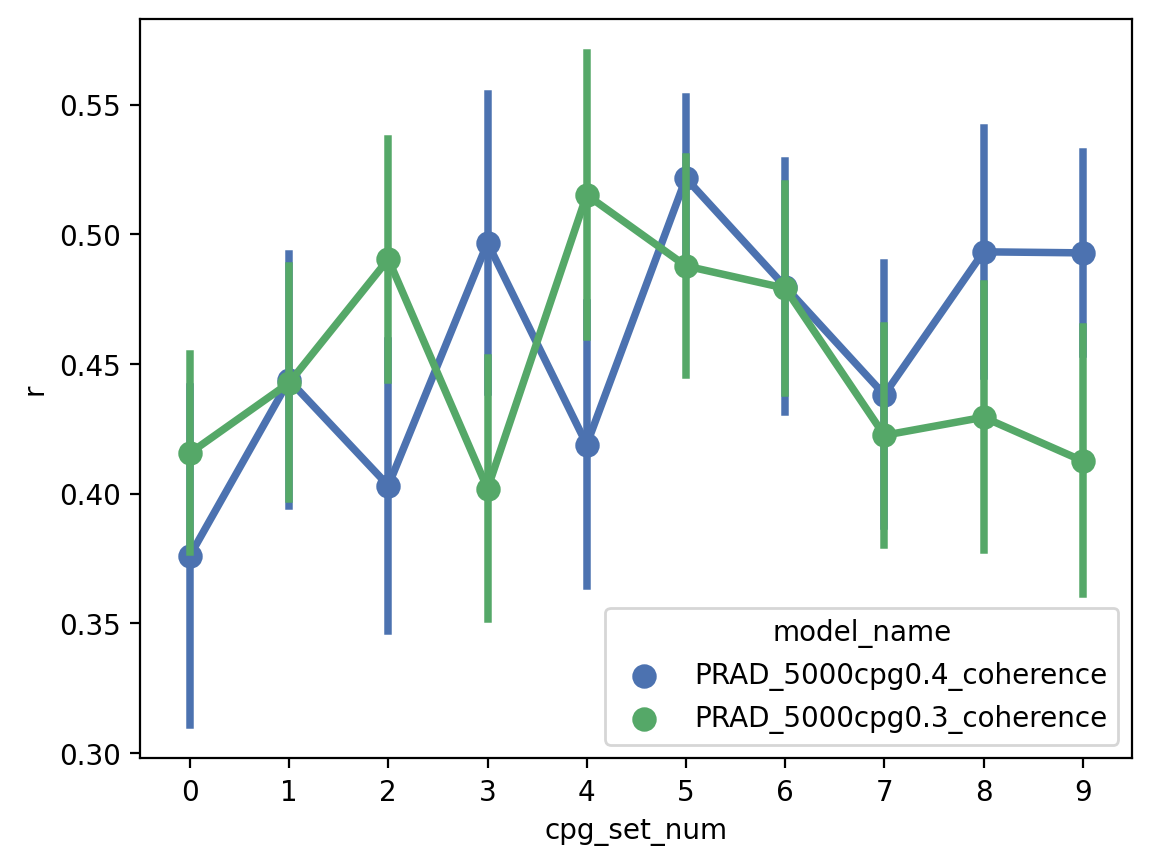

In [36]:
sns.pointplot(
    data = all_clock_perf_df.query("dist_type == 'coherence' and tissue == 'PRAD'"), y = 'r', x = 'cpg_set_num', errorbar='se', hue = 'model_name'
    )

<Axes: xlabel='cpg_set_num', ylabel='r'>

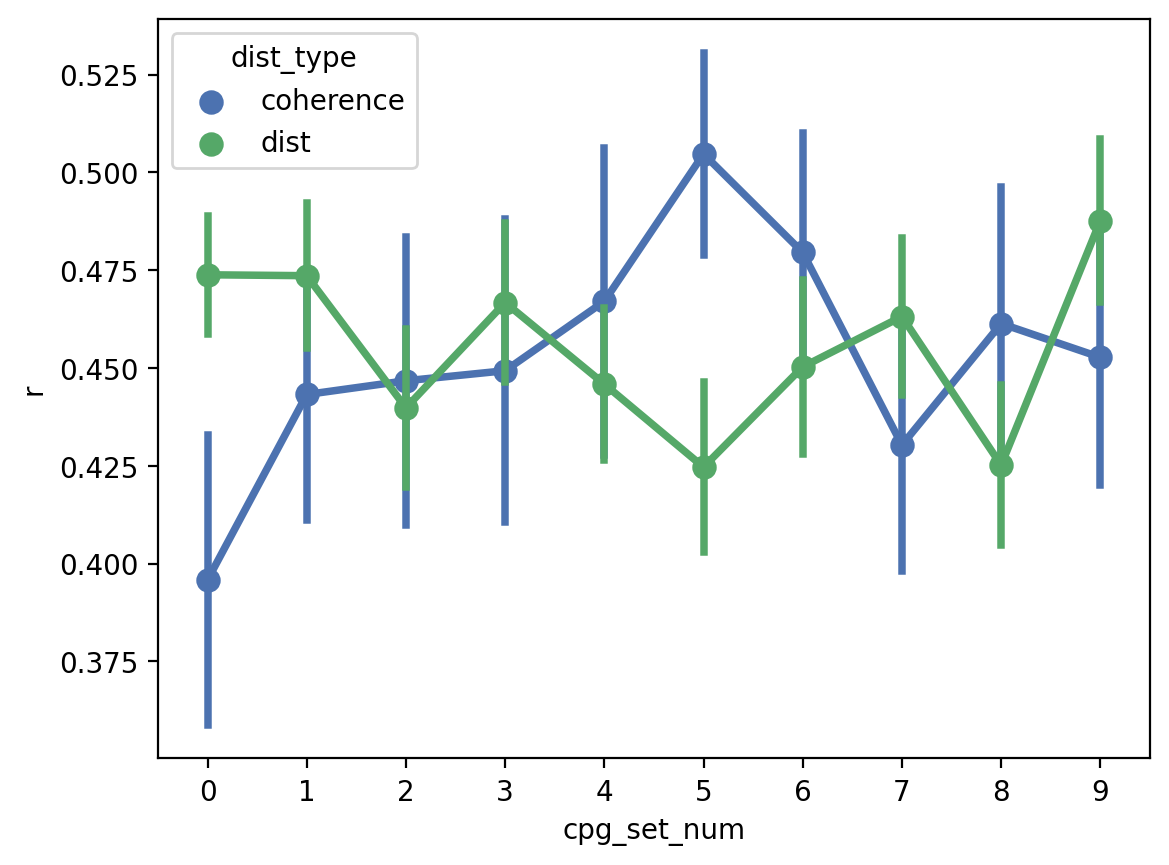

In [38]:
sns.pointplot(
    data = all_clock_perf_df.query("tissue == 'PRAD'"), y = 'r', x = 'cpg_set_num', errorbar='se', hue = 'dist_type'
    )

<Axes: xlabel='cpg_set_num', ylabel='r'>

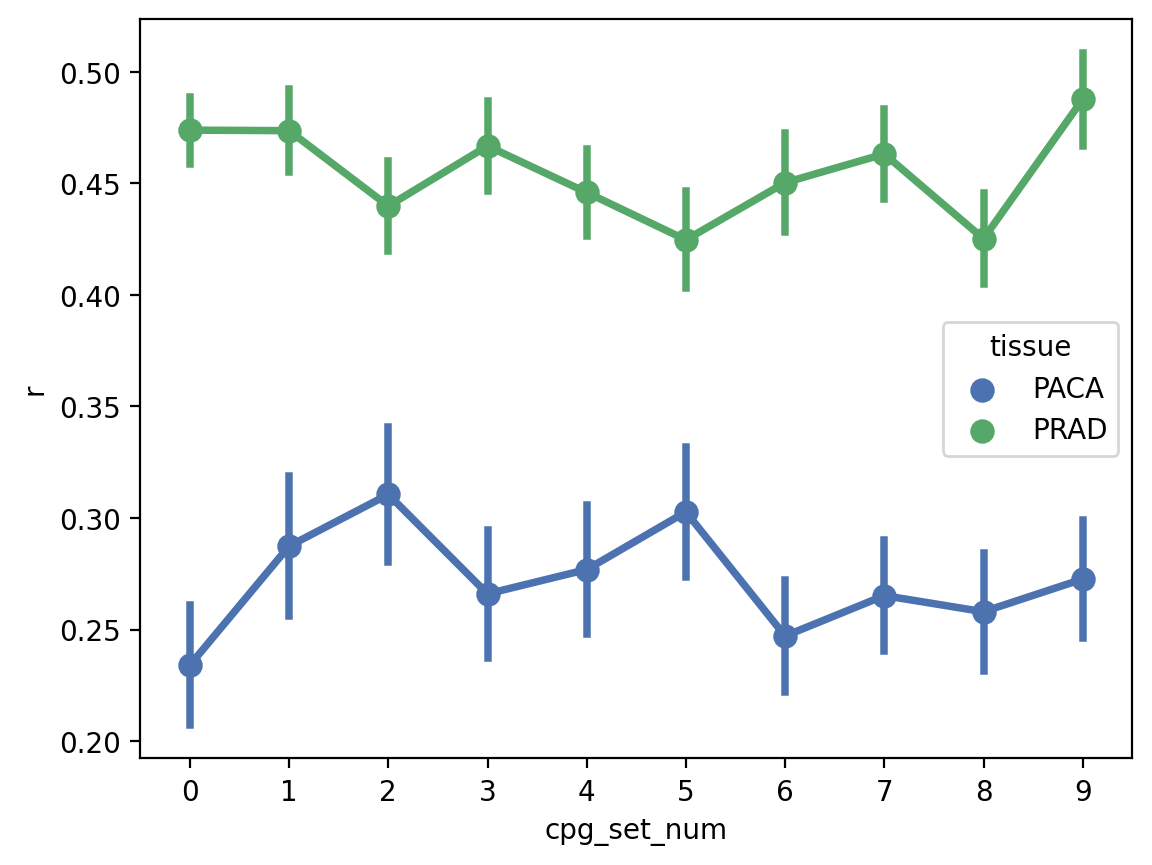

In [40]:
sns.pointplot(
    data = all_clock_perf_df.query("dist_type == 'dist'"), y = 'r', x = 'cpg_set_num', errorbar='se', hue = 'tissue', hue_order = ['PACA', 'PRAD']
)

<Axes: xlabel='cpg_set_num', ylabel='r'>

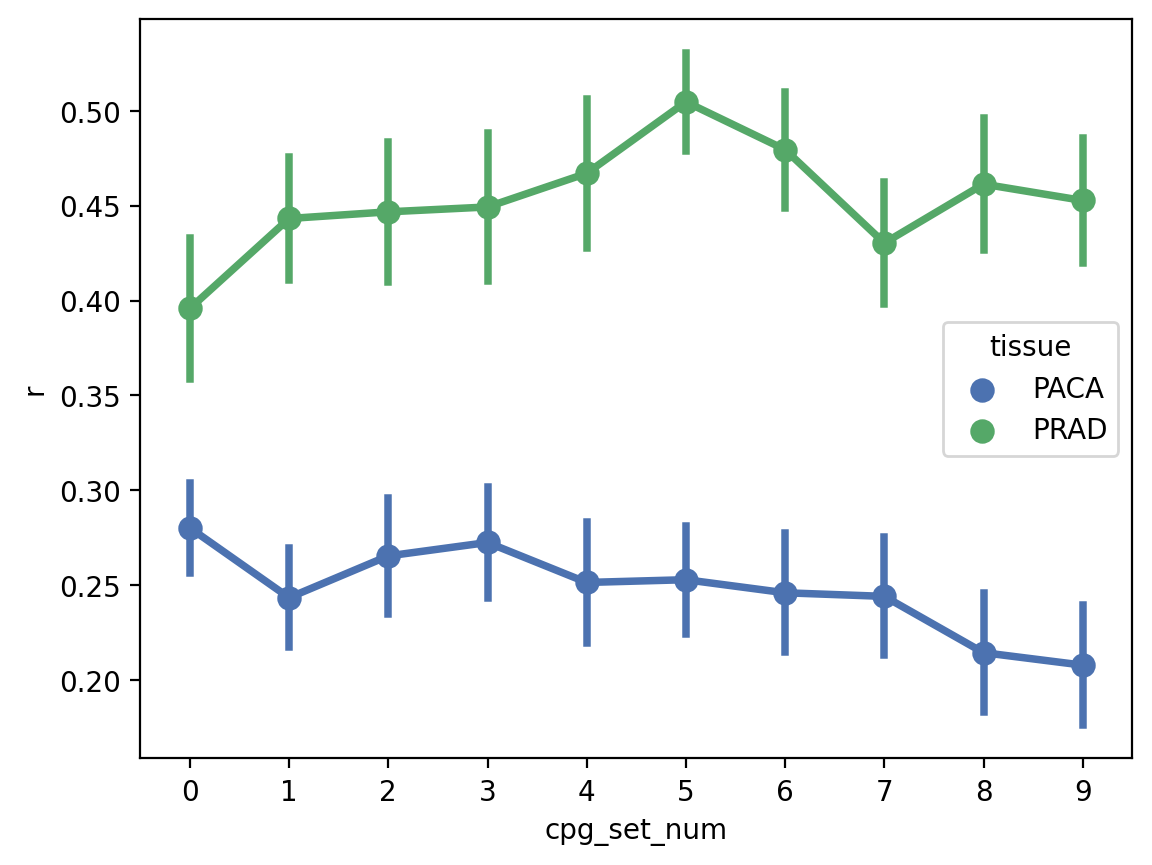

In [41]:
sns.pointplot(
    data = all_clock_perf_df.query("dist_type == 'coherence'"), y = 'r', x = 'cpg_set_num', errorbar='se', hue = 'tissue', hue_order = ['PACA', 'PRAD']
)

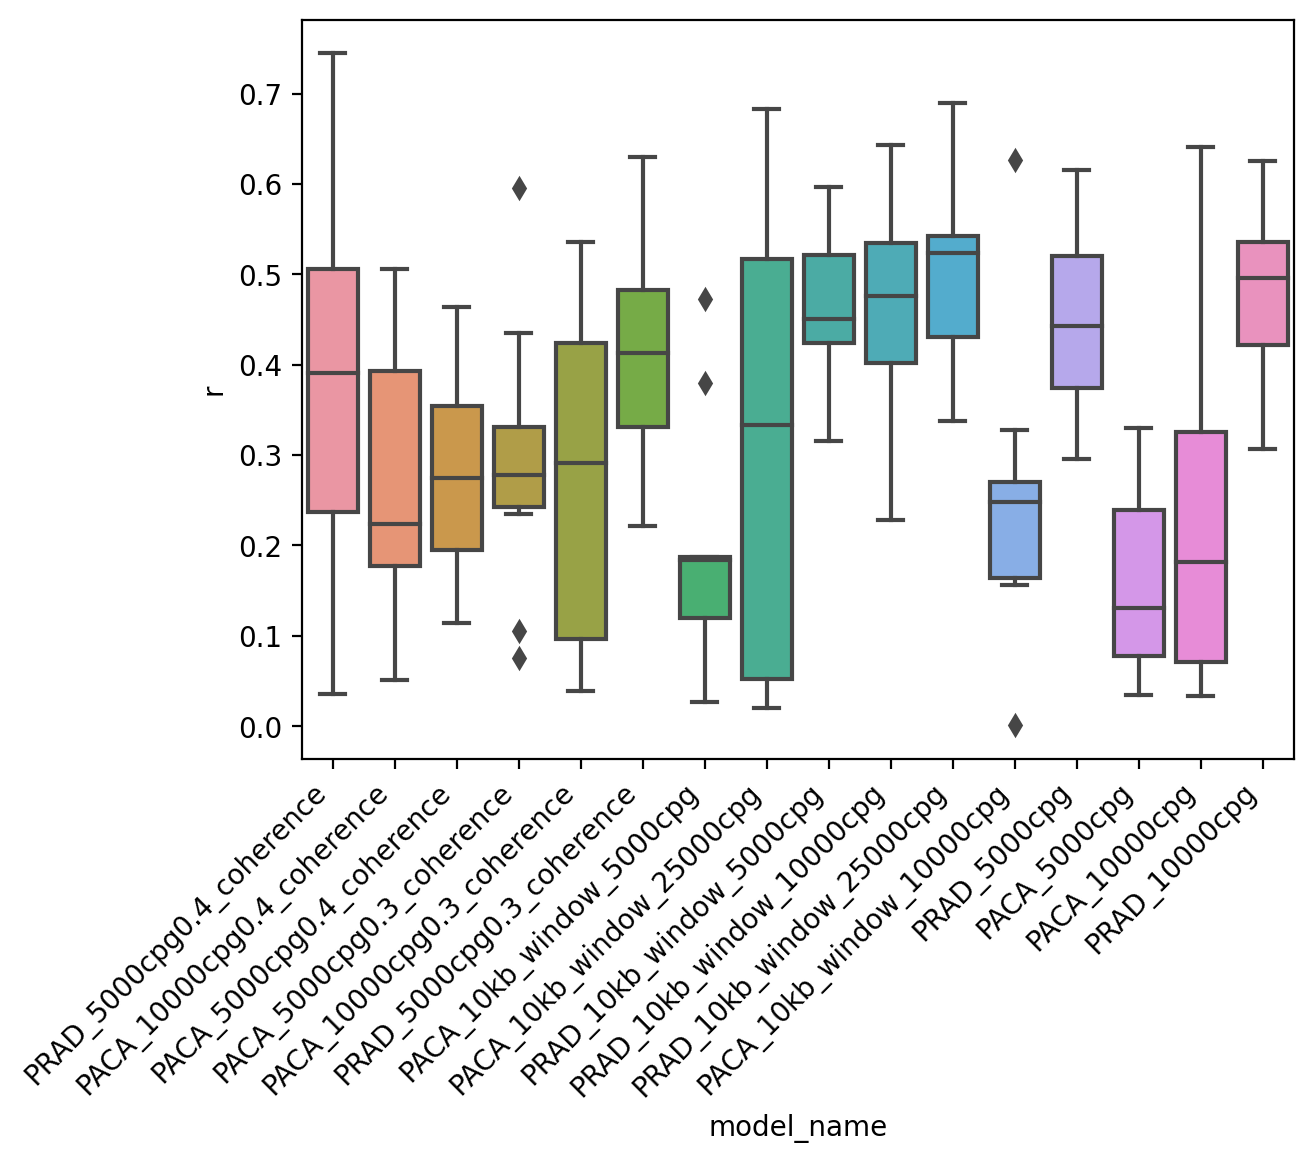

In [42]:
sns.boxplot(
    data = all_clock_perf_df.reset_index(drop=True).query("cpg_set_num == 0"), y = 'r', x='model_name'
    )
# angle x ticks
_ = plt.xticks(rotation=45, ha='right')

#### Compare performance by average burden-mf corr of the set

In [30]:
# read back in the data
prad_pearson_corr_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/081423_linear_methyl_pred_output/icgc_mut_burden_feat_10kb_window_corrs/PRAD_pearson_corrs.parquet").abs().sort_values(by=prad_pearson_corr_df.columns[0], ascending=False)

paca_pearson_corr_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/081423_linear_methyl_pred_output/icgc_mut_burden_feat_10kb_window_corrs/PACA_pearson_corrs.parquet").abs().sort_values(by=paca_pearson_corr_df.columns[0], ascending=False)

In [40]:
def get_mean_corr_by_set_num(set_num, set_size, tissue):
    """
    Assumes that corr_df is already sorted and dropped
    """
    if tissue == "prad":
        corr_df = prad_pearson_corr_df
    elif tissue == "paca":
        corr_df = paca_pearson_corr_df
    corr_vals = corr_df.iloc[set_num * set_size : (set_num + 1) * set_size - 1, :].values
    return np.mean(corr_vals), np.mean(corr_vals)

In [41]:
perf_df[['mean_corr', 'median_corr']] = perf_df.apply(
    lambda row: get_mean_corr_by_set_num(row['cpg_set_num'], int(row['model'][4:]), row['model'][:4]),
    axis=1, result_type='expand'
    )

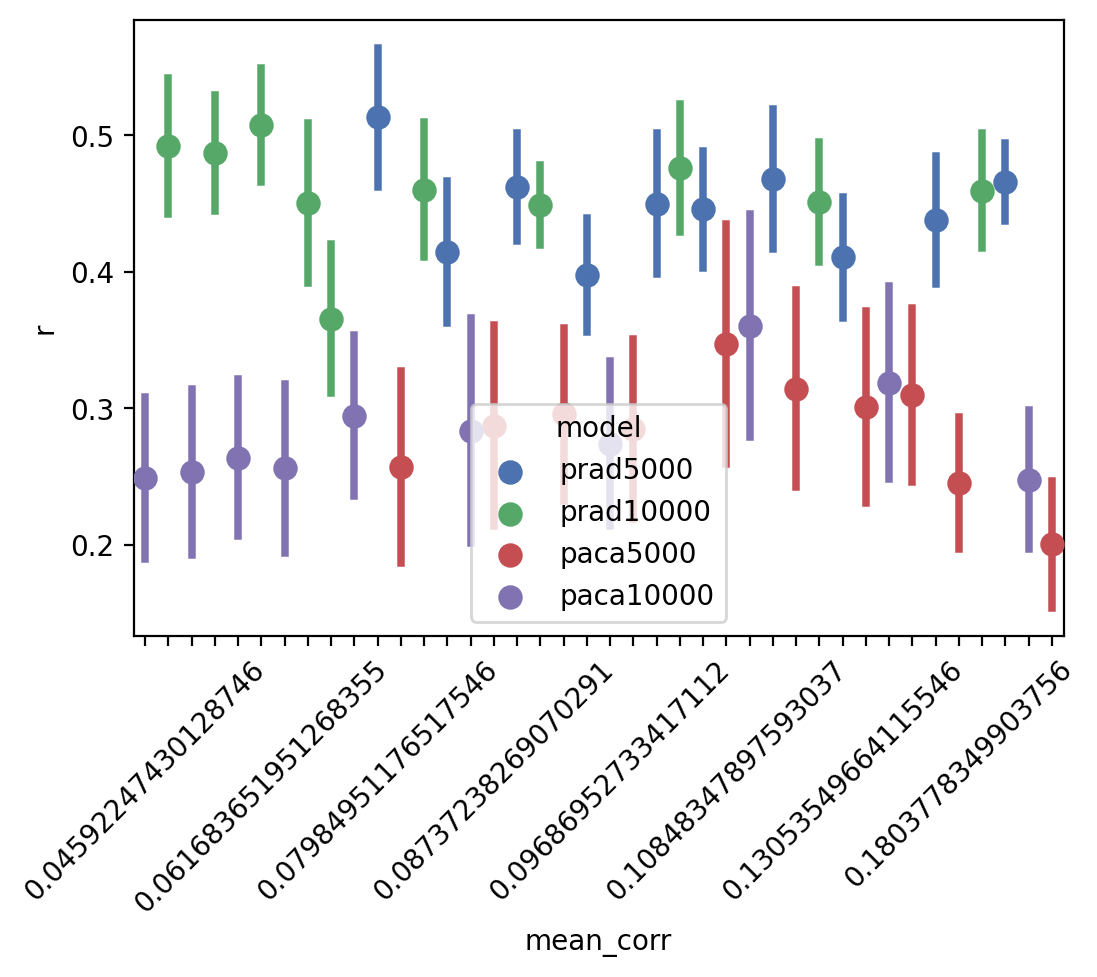

In [73]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.pointplot(data = perf_df,  y= 'r', x = 'mean_corr', hue='model', dodge = False, join =False, errorbar='se', ax = ax)
# show only every 100th x label 
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 5 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
# angle the x labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# Any CpG Clocks

In [53]:
# read in results
tissues = ['PACA', 'PRAD']
clock_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/data/final_icgc_data/actual_methyl_epi_clocks/*enet.pkl")
clocks = {}
for clock_path in clock_paths:
    for tissue in tissues:
        if tissue in clock_path:
            clocks[clock_path.split('/')[-1]] = pd.read_pickle(clock_path)
            
        
    

In [54]:
clocks

{'epiClock_ICGC_cv1_PACA_actualMethyl_enet.pkl': ElasticNetCV(cv=5, n_jobs=-1, random_state=42, selection='random', verbose=1),
 'epiClock_ICGC_cv3_PRAD_actualMethyl_enet.pkl': ElasticNetCV(cv=5, n_jobs=-1, random_state=42, selection='random', verbose=1),
 'epiClock_ICGC_cv2_PACA_actualMethyl_enet.pkl': ElasticNetCV(cv=5, n_jobs=-1, random_state=42, selection='random', verbose=1),
 'epiClock_ICGC_cv0_PRAD_actualMethyl_enet.pkl': ElasticNetCV(cv=5, n_jobs=-1, random_state=42, selection='random', verbose=1),
 'epiClock_ICGC_cv1_PRAD_actualMethyl_enet.pkl': ElasticNetCV(cv=5, n_jobs=-1, random_state=42, selection='random', verbose=1),
 'epiClock_ICGC_cv4_PACA_actualMethyl_enet.pkl': ElasticNetCV(cv=5, n_jobs=-1, random_state=42, selection='random', verbose=1),
 'epiClock_ICGC_cv4_PRAD_actualMethyl_enet.pkl': ElasticNetCV(cv=5, n_jobs=-1, random_state=42, selection='random', verbose=1),
 'epiClock_ICGC_cv0_PACA_actualMethyl_enet.pkl': ElasticNetCV(cv=5, n_jobs=-1, random_state=42, selectio

In [47]:
clock

ElasticNetCV(cv=5, n_jobs=-1, random_state=42, selection='random', verbose=1)

# pub clocks

In [73]:
horvath_clock = pd.read_csv("/cellar/users/zkoch/other_clocks/horvath.csv", skiprows=2)
pheno_clock = pd.read_csv("/cellar/users/zkoch/other_clocks/phenoAge_clock.csv")

In [9]:
hannum_clock = pd.read_csv("/cellar/users/ayl009/hannum_model.csv")

In [101]:
hannum_clock_cpgs = list(set(hannum_clock['Marker']).intersection(set(icgc_methyl_age_df_t.columns)))
clock_cpg_vector = hannum_clock.query("Marker in @hannum_clock_cpgs")['Coefficient'].values

In [115]:
hannum_pred_ages = icgc_methyl_age_df_t[hannum_clock_cpgs].dot(clock_cpg_vector)

In [118]:
# one hot encode
icgc_methyl_age_df_t['dataset'].astype('category')

sample
DO35009     PACA
DO229100    UTCA
DO229102    UTCA
DO229104    UTCA
DO48557     PAEN
            ... 
DO51105     PRAD
DO229086    UTCA
DO229091    UTCA
DO229094    UTCA
DO229096    UTCA
Name: dataset, Length: 651, dtype: category
Categories (7, object): ['CLLE', 'OV', 'PACA', 'PAEN', 'PBCA', 'PRAD', 'UTCA']

In [123]:
hannum_perf_df = pd.DataFrame({'pred': hannum_pred_ages.values, 'actual': icgc_methyl_age_df_t['age_at_index'].values, 'tissue': icgc_methyl_age_df_t['dataset'].values})
# pivot

In [127]:
hannum_perf_df.groupby('tissue').corr(method = 'spearman')

pred    actual
tissue                           
CLLE   pred    1.000000  0.456745
       actual  0.456745  1.000000
OV     pred    1.000000  0.056355
       actual  0.056355  1.000000
PACA   pred    1.000000  0.148196
       actual  0.148196  1.000000
PAEN   pred    1.000000  0.055461
       actual  0.055461  1.000000
PBCA   pred    1.000000  0.236061
       actual  0.236061  1.000000
PRAD   pred    1.000000  0.119409
       actual  0.119409  1.000000
UTCA   pred    1.000000 -0.226471
       actual -0.226471  1.000000

<Axes: xlabel='actual', ylabel='pred'>

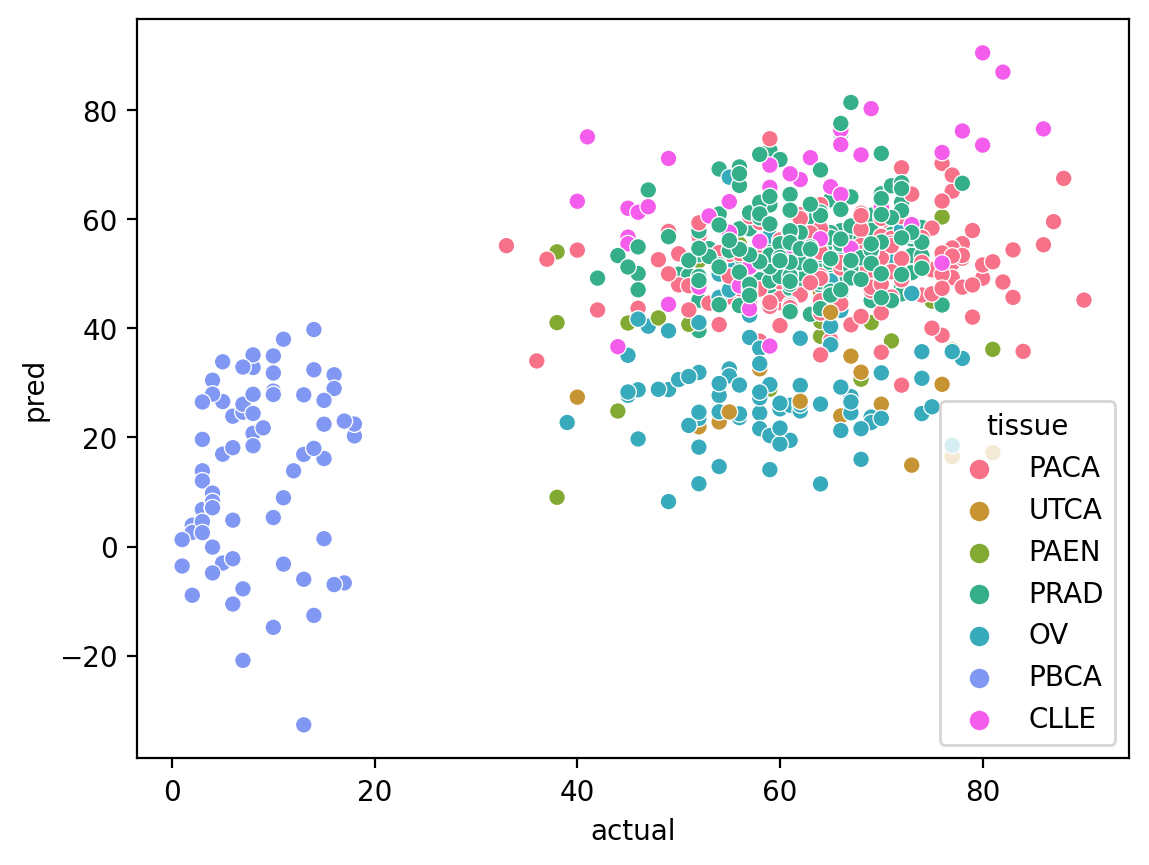

In [125]:
sns.scatterplot(data = hannum_perf_df, x = 'actual', y = 'pred', hue = 'tissue')

In [ ]:
icgc_m_df = pd.read_csv(
    "/cellar/users/zkoch/methylation_and_mutation/data/icgc/meth_array.tsv.gz",
    sep = '\t'
    )

In [4]:
d = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/data/icgc/methyl_dir/methyl_df_reshap_t.parquet")

In [26]:
d.loc[icgc_methyl_age_df_t.index, :]

NameError: name 'icgc_methyl_age_df_t' is not defined

In [13]:
d = d.T

In [14]:
hannum_clock_cpgs = list(set(hannum_clock['Marker']).intersection(set(d.columns)))
clock_cpg_vector = hannum_clock.query("Marker in @hannum_clock_cpgs")['Coefficient'].values

In [25]:
d[hannum_clock_cpgs].dot(clock_cpg_vector)

icgc_donor_id
DO10012   NaN
DO10068   NaN
DO10172   NaN
DO10236   NaN
DO10324   NaN
           ..
DO9788    NaN
DO9804    NaN
DO9812    NaN
DO9876    NaN
DO9940    NaN
Length: 2329, dtype: float64

In [19]:
clock_cpg_vector

array([-15.7   ,   1.05  ,   3.87  ,   9.62  , -11.1   ,  -6.46  ,
        -0.74  ,   5.79  ,  -2.06  ,   1.02  ,   8.95  ,   4.85  ,
         2.48  ,   8.35  ,   1.79  ,  -7.1   ,  10.7   ,   3.72  ,
        -2.72  ,   4.01  ,  -1.81  ,  10.2   ,  -3.16  ,   5.67  ,
       -12.6   ,  10.8   ,   4.42  ,   9.42  , -13.1   , -10.7   ,
        -5.8   ,  19.1   ,  10.7   ,  27.3   ,  13.7   , -20.7   ,
        -3.31  ,   9.41  ,  -1.42  ,  -1.6   ,   3.03  , -10.6   ,
        13.4   ,  -0.392 ,   0.0859,  11.6   ,  14.7   ,  23.7   ,
        13.4   , -10.2   ,   8.21  ,  -5.66  ,   8.85  ,  -2.98  ,
       -20.6   ,   8.4   ,  -4.37  ,   8.39  , -15.8   ,  28.    ,
        11.9   ,   2.87  ,  19.1   ,  -4.37  ,  17.1   , -12.5   ,
        -4.29  ,  -4.04  ,   3.11  , -22.7   ,  -6.92  ])

In [21]:
d.dot(clock_cpg_vector)

ValueError: Dot product shape mismatch, (2329, 487177) vs (71,)

<Axes: >

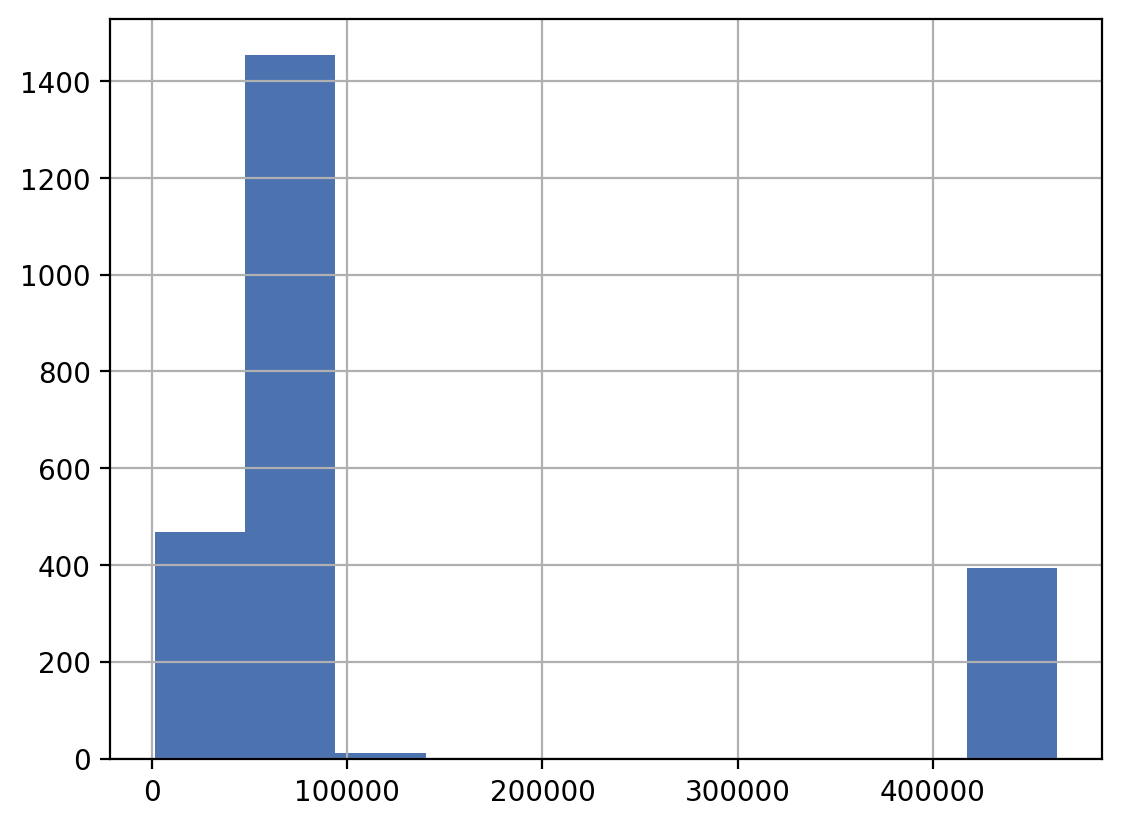

In [8]:
d.isna().sum().hist()

In [ ]:
# open directory of parquet files using dask
